In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [52]:
pip install pydot graphviz

**Load Dataset**

In [53]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

In [54]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

**Preprocessing**

In [55]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask - 1 # convert to zero based indexing
    return input_image, input_mask

def load_train_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # data augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_test_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [56]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [57]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

**Explanatory Data Analysis**

In [58]:
def display_sample(image_list):
    plt.figure(figsize=(10,10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

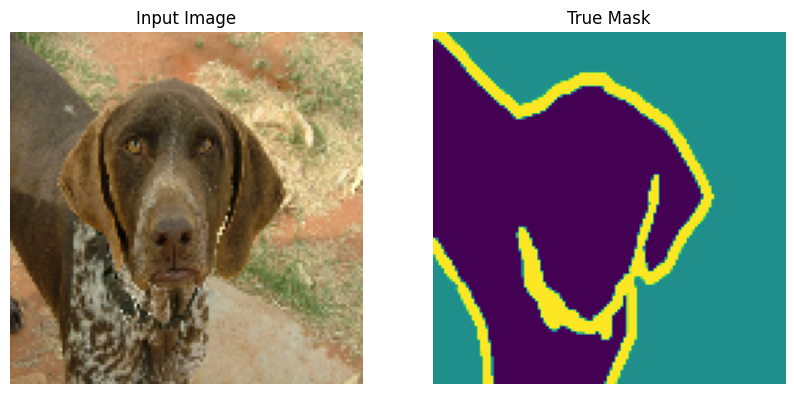

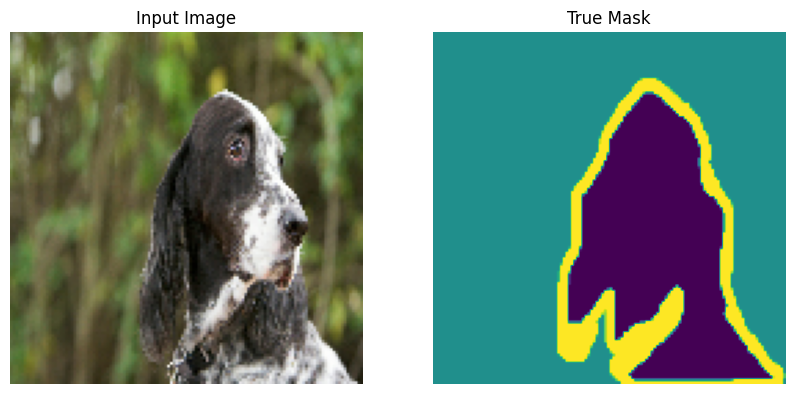

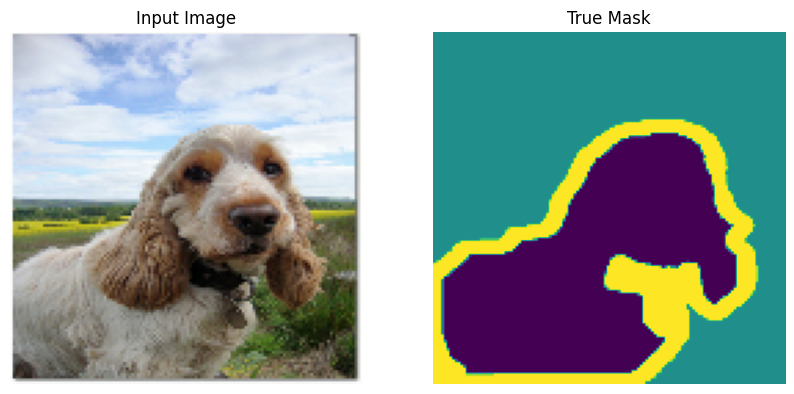

In [59]:
for images, masks in train_dataset.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

**Define U-Net Model**

In [60]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [61]:
def build_unet_model(output_channels):
    # input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # encoder - downsample
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # intermediate block
    intermediate_block = double_conv_block(p4, 1024)

    # decoder - upsample
    u6 = upsample_block(intermediate_block, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # output layer
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(u9)

    # unet model
    unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

    return unet_model

In [ ]:
# for images, masks in train_dataset.take(1):
#     sample_image, sample_mask = images[0], masks[0]
# sample_mask[60]


In [62]:

output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
EPOCHS = 20
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=test_dataset)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.5590 - loss: 0.9434 - val_accuracy: 0.6150 - val_loss: 0.8099
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.6754 - loss: 0.7196 - val_accuracy: 0.7352 - val_loss: 0.6500
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7425 - loss: 0.6194 - val_accuracy: 0.7745 - val_loss: 0.5405
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 824ms/step - accuracy: 0.7763 - loss: 0.5418 - val_accuracy: 0.7807 - val_loss: 0.5227
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7912 - loss: 0.5152 - val_accuracy: 0.8098 - val_loss: 0.4604
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8071 - loss: 0.4707 - val_accuracy: 0.8190 - val_loss: 0.4640
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8251 - loss: 0.4280 - val_accuracy: 0.8325 - val_loss: 0.4283
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 817ms/step - accuracy: 0.8349 - loss: 0.4052 - val_accuracy: 0.8341 - val_loss: 0.4135
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8357 - loss: 0.4012 - val_accuracy: 0.8333 - val_loss: 0.4216
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 825ms/step - accuracy: 0.8463 - loss: 0.3763 - val_accuracy: 0.8428 - val_loss: 

**Visualize the Results**

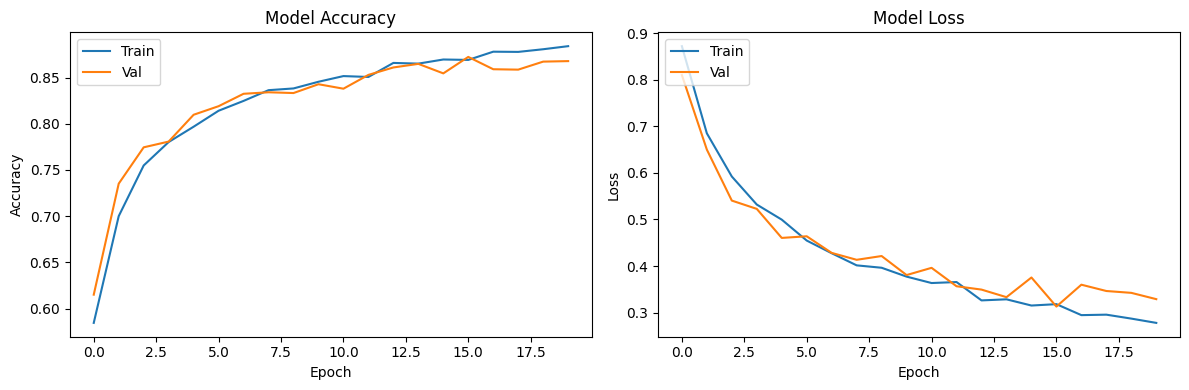

In [39]:
#plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()


**Test Predictions**

In [40]:

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])

In [ ]:

# for image, mask in test_dataset.take(1):
#     pred_mask = model.predict(image)
# pred_mask = tf.argmax(pred_mask, axis=-1)
# print(np.array(pred_mask.shape))
# pred_mask = pred_mask[..., tf.newaxis]
# print(pred_mask[0].shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


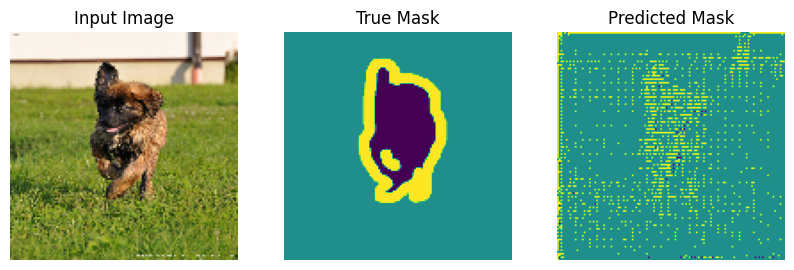

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


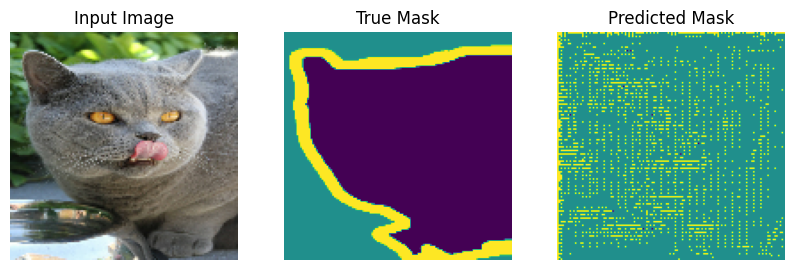

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


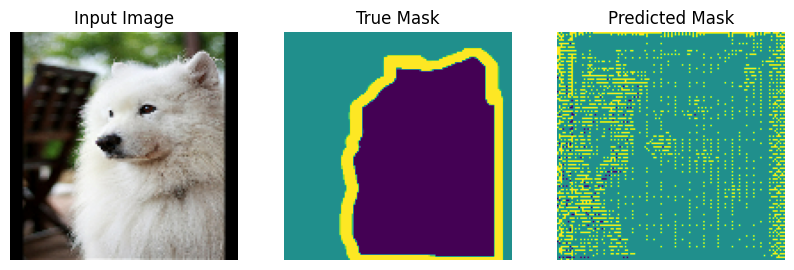

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


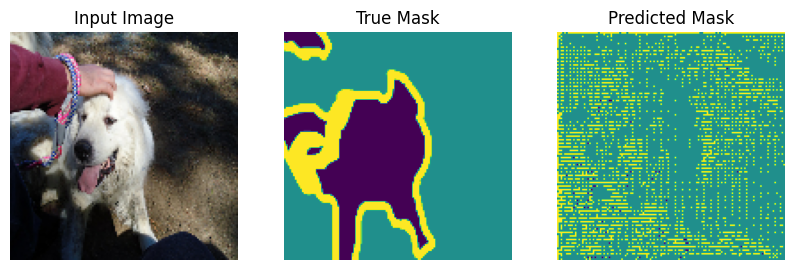

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


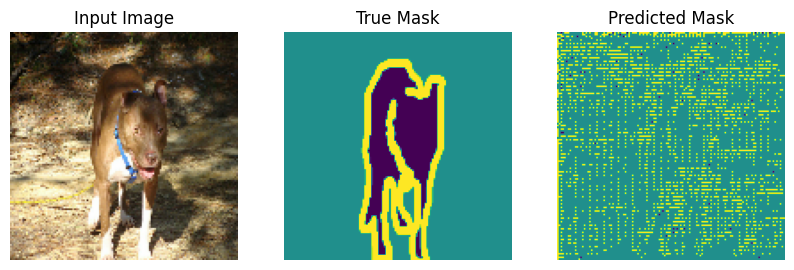

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


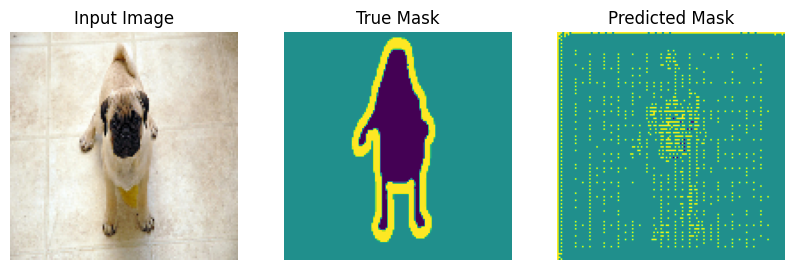

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


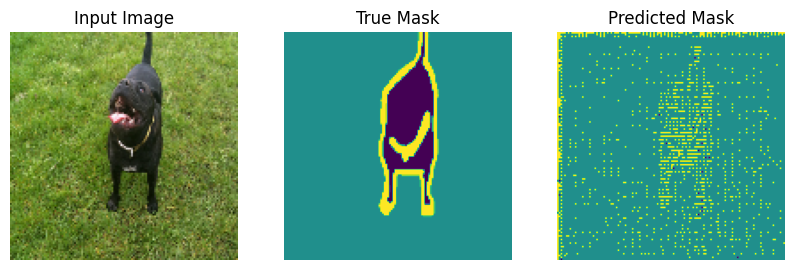

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


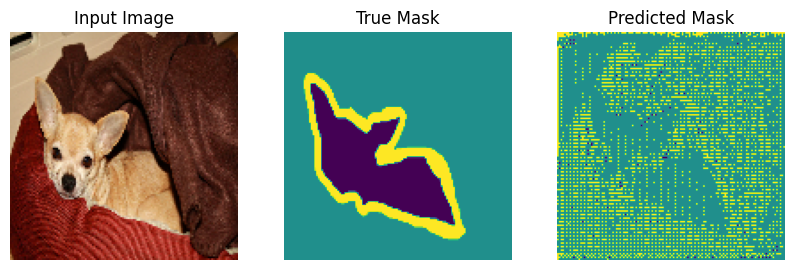

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


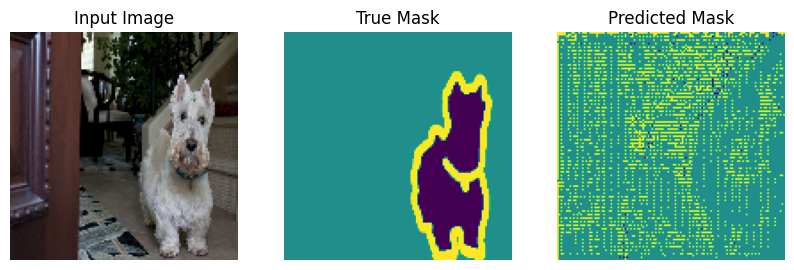

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


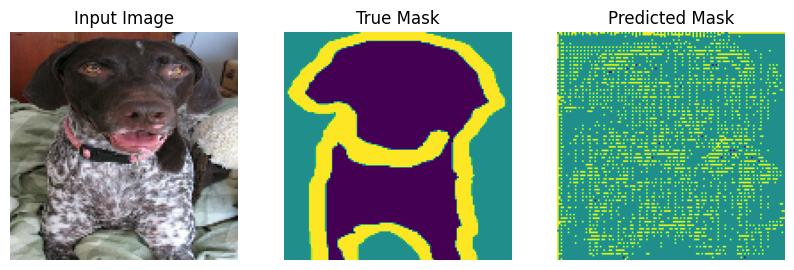

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


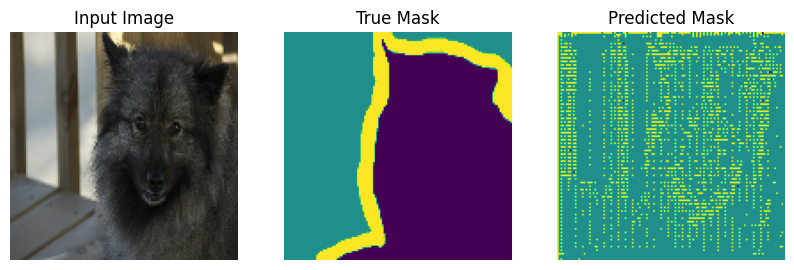

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


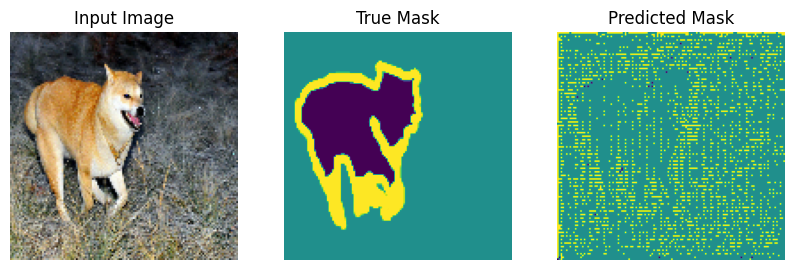

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


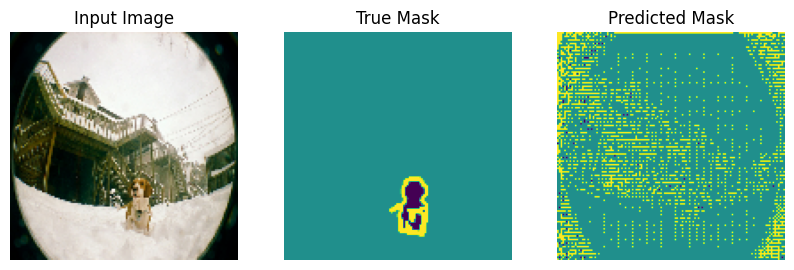

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


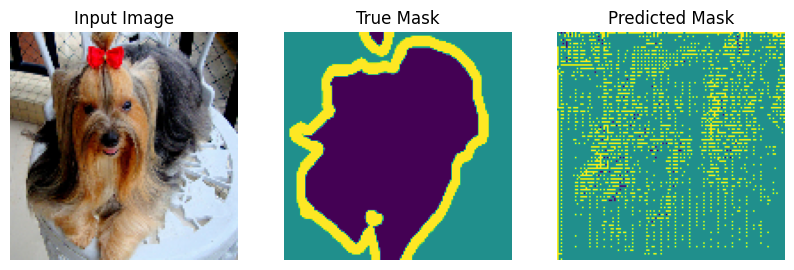

In [64]:
show_predictions(test_dataset, 14)